# Image Classification with Deep Learning

Welcome to the **BILD 2025 Summer School** hands-on session on medical image classification! This notebook will guide you through the complete pipeline of building and critically evaluating a model to identify diseases in chest X-rays.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/albarqounilab/BILD-Summer-School/blob/main/notebooks/day1/classification_exercise.ipynb)

![alt_text](https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/helpers/notebook-banner.png)

BILD 2025 is organized under the umbrella of the [Strategic Arab-German Network for Affordable and Democratized AI in Healthcare (SANAD)](https://albarqouni.github.io/funded/sanad/), uniting academic excellence and technological innovation across borders. This year’s edition is organized by the [Albarqouni Lab](https://albarqouni.github.io/) at the [University Hospital Bonn](https://www.ukbonn.de/) and the [University of Bonn](https://www.uni-bonn.de/en). We are proud to partner with leading institutions in the region—Lebanese American University, University of Tunis El Manar, and Duhok Polytechnic University — to deliver a truly international learning experience. Over five intensive days in Tunis, you will explore cutting-edge deep-learning techniques for medical imaging through expert lectures, hands-on labs, and collaborative case studies. Engage with peers and faculty from Germany, Lebanon, Iraq, and Tunisia as you develop practical skills in building and deploying AI models for real-world healthcare challenges. We look forward to an inspiring week of interdisciplinary exchange and the shared commitment to advancing affordable, life-saving AI in medicine.


## Chest-X-Ray Classification [90 mins]

### Today's Goals

This session is a practical journey into building and validating a clinical AI tool. By the end of this notebook, you will be able to:

-  **Prepare Medical Imaging Data**: Load, preprocess, and structure chest X-ray images and their corresponding metadata.
-  **Perform Exploratory Data Analysis (EDA) for Fairness**: Investigate dataset demographics (age, sex) to identify potential sources of bias before training.
-  **Train and Benchmark Classifiers**: Fine-tune multiple state-of-the-art CNN architectures (e.g., DenseNet, EfficientNet) for disease classification.
-  **Master Classification Metrics**: Implement and interpret evaluation metrics such as Accuracy, Precision, Recall, F1-score, and ROC-AUC.
-  **Conduct a Fairness Audit**: Evaluate model performance across different demographic subgroups to detect potential biases in predictions.
-  **Apply Explainable AI (XAI)**: Use Grad-CAM to visualize model attention and ensure predictions are based on clinically relevant features.

### Objectives

You’ll see how AI can be trained to identify pathological findings in chest X-rays, a crucial step in computer-assisted diagnosis. You’ll also apply your classification skills to a challenging real-world problem in medical imaging, while learning how to interpret and validate model predictions beyond raw accuracy scores.

### Dataset

The [NIH ChestX-ray-14](https://nihcc.app.box.com/v/ChestXray-NIHCC) dataset is a large collection of chest X-ray images. Each image comes with information about the patient and labels that tell us which diseases (if any) are present. This dataset is widely used in medical AI research because it helps us train and test models to recognize diseases from X-ray images.

**What does the dataset contain?**
1. Chest X-ray images, each in PNG format. These are pictures of the inside of the chest, showing the lungs and heart.
2. A metadata file (`Data_Entry_2017.csv`) that lists information about each image, such as:
   - Which diseases are present (if any)
   - Patient age and gender
   - How the image was taken
3. A file with bounding boxes (`BBox_List_2017.csv`) for about 1,000 images. These boxes show exactly where a disease is located in the image.
4. Files that split the data into training and test sets. This is important because we want to train our model on some images and test it on others to see how well it works on new data.

**Why do we use this dataset?**
- It is large and diverse, which helps our model learn better.
- It has real medical labels, making our project more realistic.
- It allows us to practice both classification (is there a disease?) and detection (where is the disease?).

In this notebook, we will use a smaller sample of this dataset and pre-trained models to make the exercises faster and easier to follow.


## 1. Environment Setup

We install and import required libraries. Run this once per new environment.

> **Note:** The cell will install packages (internet required). If you're offline, skip installation and ensure the environment already has the packages.


In [ ]:
#@title import libraries (2 minutes)
# Library Installations
!pip install pydicom SimpleITK albumentations torchmetrics grad-cam -q

# Core Library Imports
import os
import sys, math, random, time, warnings
from glob import glob
from pathlib import Path
import gc

# Data Handling and Processing
import numpy as np
import pandas as pd
import cv2
import pydicom
from PIL import Image

# Deep Learning with PyTorch & Torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms, models
from torch.optim.lr_scheduler import OneCycleLR

# Visualization & Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay
from torchmetrics.classification import BinaryAUROC

# Explainability (XAI)
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image

# Environment Configuration
warnings.filterwarnings("ignore")

# Ensure reproducibility
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

RANDOM_SEED = 42
seed_everything(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Setup complete. Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.7 MB/s eta 0:00:00


## 2. The Dataset: ChestX-ray14 (NIH) ( 3 minutes)

We’ll use the NIH ChestX-ray14 dataset:

- Size: ~9.2GB subset

- Format: JPG images + accompanying CSV files with labels

- Source: NIH Clinical Center

**What does the dataset contain?**
1. A subset of over 20k chest X-ray images, each in PNG format. These are pictures of the inside of the chest, showing the lungs and heart.
2. A metadata file (`Data_Entry_2017.csv`) that lists information about each image, such as:
   - Which diseases are present (if any)
   - Patient age and gender
   - How the image was taken
3. A file with bounding boxes (`BBox_List_2017.csv`) for about 1,000 images. These boxes show exactly where a disease is located in the image.
4. Files that split the data into training and test sets. This is important because we want to train our model on some images and test it on others to see how well it works on new data.

### 2.1 Downloading the Data (3 minutes)
Before we can work with the data, we need to download and unzip it. This means we are copying the files from the internet to our computer and making them ready to use.

**Why do we do this?**
- Machine learning models need data to learn from. Downloading the dataset gives us the images and labels we need for our project.
- Unzipping extracts the files from a compressed format so we can access them easily in our code.

**Instructions:**
- If you have not downloaded the dataset yet, run the following cells to download and unzip the files.
- If you already have the data, you can skip these steps by adding a `#` before the `!` in the code (this comments out the line so it won't run).
- You can also change the `DATA_PATH` variable if you want to store the data in a different folder.

> **Tip:** Downloading large datasets can take a while, depending on your internet speed.


In [ ]:
DATA_PATH = "./Classification"
!pip -q install -U "huggingface_hub[cli]" -q
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/data_cxr8.zip" --local-dir ./
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/csv.zip" --local-dir ./

In [ ]:
!unzip -q ./Classification/data_cxr8.zip -d {DATA_PATH}
!unzip -q ./Classification/csv.zip -d {DATA_PATH}

### 2.3. Data Exploration & Fairness Pre-Analysis

Before we write a single line of model code, we must understand our data. This process, known as **Exploratory Data Analysis (EDA)**, is our first and most important quality control step. A model trained on poorly understood or biased data will produce untrustworthy results, a risk we cannot afford in a clinical setting.

In this section, we will:
1.  **Visualize the Data:** Perform a "sanity check" to ensure images and labels are loading correctly.
2.  **Analyze Label Distribution:** Understand the prevalence of different pathologies to identify class imbalance.
3.  **Conduct a Pre-training Fairness Audit:** Investigate the demographic makeup of our dataset (patient age and sex). An imbalance here can lead to a model that performs poorly for underrepresented groups. This proactive check is a cornerstone of building responsible AI.

Let's first start by understanding the data structure inside the Classification/ folder:

```
Classification/
  images/                              # Contains chest X-ray PNG images
    00000005_003.png
    00000005_006.png
    00000005_007.png
    ...
  metadata.csv                         # Full metadata: image IDs, labels, patient info
  metadata_filtered.csv                # Processed/filtered metadata
  train_df.csv                         # Training set split
  val_df.csv                           # Validation set split
  test_df.csv                          # Test set split
  train_val_list.txt                   # Combined train/val list
  test_list.txt                        # Test image list
  densenet121-classification.pth       # Pretrained DenseNet121 model weights
  efficientnet-classification.pth      # Pretrained EfficientNet model weights
  swintransformer-classification.pth   # Pretrained Swin Transformer model weights

```

### Load dataframe metadata

A **dataframe** is a table of data, like a spreadsheet, that we can easily work with in Python using the pandas library. Here, we load the metadata for all our images. This metadata tells us important information about each image, such as which diseases are present, the patient ID, and more. Loading this information helps us organize and prepare our data for training and testing our model.

In [ ]:
# Load and observe available data
DATA_PATH = "./Classification"
metadata_df = pd.read_csv(f'{DATA_PATH}/metadata.csv')
metadata_df#.head() # Print the 5 fist rows of the dataframe

In our dataset, we have two types of information:

- A metadata file (metadata.csv) that lists more than 112,000 entries, one for each expected X-ray.

- A folder of actual images, which contains only 24,502 files.

Now the question is: do all metadata entries have a corresponding image file? Let’s visualize this relationship.

<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/metadata_images_relationship.png" width="600">



This view makes it even clearer:

- Most of the data exists only in the metadata file, but without images, we can’t use them.

- The overlap gives us the real working subset we’ll use for training and evaluation: 24,502 chest X-rays.

- The orange area for ‘Only in Images’ is empty, meaning every image in the folder has a metadata entry — which is good for consistency.

Now we need to make sure that the information in our dataframe matches the images we actually downloaded. This step filters out any entries in the metadata that do not have a corresponding image file, so we only work with images that are available on our computer.

In [ ]:
imgs = glob(f'{DATA_PATH}/images/*')
imgs_basename = [os.path.basename(i) for i in imgs]

metadata_df = metadata_df.loc[metadata_df['Image Index'].isin(imgs_basename)]
metadata_df.shape

In [ ]:
#@title Plot Patient Images

import matplotlib.pyplot as plt
import random

# Show a few random patient images
def plot_random_images(metadata_df, data_path, n=6):
    """Plots n random images with their labels."""
    sample_df = metadata_df.sample(n)
    plt.figure(figsize=(15, 8))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(data_path, "images", row["Image Index"])
        img = plt.imread(img_path)

        plt.subplot(2, n//2, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Patient {row['Patient ID']}\nLabel: {row['Finding Labels']}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
plot_random_images(metadata_df, DATA_PATH, n=6)


##3. Data Splitting & Preparation

#### Deep Dive: The Golden Rule of Medical AI - Splitting by Patient

How we split our data is one of the most critical decisions in the entire project. In medical imaging, there is one golden rule: **always split by patient, never by image.**

**Why is this so important?**
Slices or images from the same patient are highly correlated. They share the same unique anatomy, come from the same scanner session, and may have similar imaging artifacts.

If we were to randomly put some images from Patient A into the training set and others into the test set, our model could "cheat." It might learn to recognize Patient A's specific anatomy instead of the general features of the disease. This is a critical error called **data leakage**. It leads to an artificially high performance score during testing, but the model would fail dramatically when deployed on a new, unseen patient.

By splitting our data at the patient level, we guarantee that all images from a single patient belong exclusively to either the training, validation, or test set. This ensures our final evaluation is an honest measure of the model's ability to generalize to new individuals.

### 3.1 Load patient splits

To train and evaluate our model properly, we need to split our data into different groups:
- **Training set:** Used to teach the model.
- **Validation set:** Used to check how well the model is learning during training.
- **Test set:** Used to see how well the model works on completely new data.

In this step, we load lists of which images belong to each group. This helps us make sure that the model is tested on images it has never seen before, which is important for getting a fair measure of its performance.

In [ ]:
train_val_patients = pd.read_csv(f'{DATA_PATH}/train_val_list.txt', header=None, names=['patientId'])
test_patients = pd.read_csv(f'{DATA_PATH}/test_list.txt', header=None, names=['patientId'])

The `.txt` files contain lists of image names that belong to the training/validation or test sets. To use these splits, we need to match the image names in these files with the information in our main database (`metadata.csv`). This way, we know which images and labels go into each group for training and testing.

### 3.2 Handle targets

In machine learning, a **target** is what we want the model to predict. For this project, the target is the disease label for each image. In this step, we prepare the target labels so that our model can learn to predict them. This may involve simplifying the labels or grouping them in a way that makes the problem easier to solve.

In the next step, we look at how many times each disease label appears in our data. Some diseases are very rare, which can make it hard for the model to learn about them. To keep things simple and make sure our model has enough examples to learn from, we will remove labels that appear less than 1,500 times.

In [ ]:
# pd.set_option('display.max_rows', None)
label_counts = metadata_df['Finding Labels'].value_counts()
print("Label distributions:")
print(label_counts)
# pd.reset_option('display.max_rows')

We remove rare labels (diseases that appear in fewer than 1,500 images) so that our model has enough examples to learn from. This helps the model focus on the most common diseases and improves its ability to make accurate predictions.

After filtering out rare labels, we are left with the most common disease categories. The table below shows how many images belong to each label. This helps us understand the balance of our dataset and which diseases our model will learn to recognize.

First, we look at how many images there are for each disease label. This helps us see if some diseases are much more common than others, which can affect how well our model learns.

In [ ]:
label_counts = metadata_df['Finding Labels'].value_counts()
rare_labels = label_counts[label_counts < 1500].index
rare_labels

Now we update our data table (DataFrame) to remove any images with rare disease labels. This makes sure our model only sees images with the most common labels, which helps it learn better.

In [ ]:
metadata_df_filtered = metadata_df[~metadata_df['Finding Labels'].isin(rare_labels)].copy()

print(f"Original shape: {metadata_df.shape}")
print(f"Filtered shape: {metadata_df_filtered.shape}")

In [ ]:
metadata_df_filtered['Finding Labels'].value_counts()

To make our task easier, we will turn the problem into a **binary classification** problem. This means the model will learn to answer a simple question: Is this X-ray healthy or does it show signs of disease?

- **Class 0 (Negative):** Images labeled as 'No Finding' (healthy)
- **Class 1 (Positive):** Images with any disease label (pathology present)

This approach is common in deep learning when starting out, because it is easier for the model to learn to distinguish between just two categories. The category we want the model to predict is called the **target class**. Here, you can also try focusing on a specific disease (like 'Effusion') or experiment with more classes to see how the model behaves.

In [ ]:
pathology_ = "Effusion"  #@param ['Infiltration', 'Atelectasis', 'Effusion', 'Nodule', 'Pneumothorax', 'Mass']
keep = {
    'No Finding', pathology_,
}

# split each cell into a list, then keep rows where at least one element is in `keep`
df_filtered = metadata_df_filtered[
    metadata_df_filtered['Finding Labels']
      .str.split('|')                         # or .str.split(',') if comma‑separated
      .apply(lambda labels: any(lbl in keep for lbl in labels))
].copy()
df_filtered['Finding Labels'].value_counts()

We can further clean our dataset by selecting only one **view acquisition** type for our classifier. 'View acquisition' refers to the way the X-ray image was taken (for example, from the front or the side). Using only one type (like 'PA' for posteroanterior) helps the model learn more consistently, because all images will look similar in terms of orientation.

In [ ]:
df_filtered = df_filtered[df_filtered["View Position"] == 'PA']
df_filtered['View Position'].value_counts()

Now we create a new column called `Binary Label` in our data. This column will have a value of 0 for healthy images and 1 for images with any disease. This process is called **label encoding** and is very common in deep learning, because models work best with numbers instead of text.

In [ ]:
df_filtered['Binary Label'] = (df_filtered['Finding Labels'] != 'No Finding').astype(int)
df_filtered['Binary Label'].value_counts()

### 3.3 Balance Classes & Prepare Subset

#### Deep Dive: The Problem of Class Imbalance

In real-world medical datasets, some conditions are far more common than others. When we look at the `value_counts()`, we see a long tail of rare findings. This presents a challenge:

1.  **Learning Difficulty:** A model can't learn to recognize a disease from only a handful of examples. It will likely overfit to those specific images rather than learning generalizable features.
2.  **Evaluation unreliability:** Metrics can be misleading. A model could achieve 99% accuracy by simply always predicting the majority class (e.g., "No Finding").

To build a focused and effective model for this session, we will simplify the problem. We will first filter out very rare labels and then convert this into a **binary classification** task: predicting the presence or absence of a specific, common pathology versus a healthy state ('No Finding'). Now we balance the dataset by limiting the number of examples per class. This ensures that the model sees a similar number of positive (disease) and negative (healthy) examples during training.

We use a widely used Sampling method: **Undersampling** majority class in order to speed up training, and balance our pathology class at the same time.

In [ ]:
# Separate majority and minority classes
df_majority = df_filtered[df_filtered['Binary Label'] == 0]
df_minority = df_filtered[df_filtered['Binary Label'] == 1]

# Undersample majority class
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=RANDOM_SEED)

# Concatenate minority class with undersampled majority class
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the balanced dataframe
df_filtered = df_balanced.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"Balanced dataset size: {df_filtered.shape[0]}")
print("Final class distribution after undersampling:")
print(df_filtered['Binary Label'].value_counts())

### 3.4 Train / Test Split
Now we use the lists of patient IDs to split our data into a **training set** (used to teach the model) and a **test set** (used to check how well the model works on new, unseen data). This is called a **train-test split** and is a key step in building reliable machine learning models.

But first we extract the train_val and test set `train_val_list.txt` and `test_list.txt` from `train_val_patients` and `test_patients`, by comparing the `Image Index` from our filtere dataframe with the `patientID` list so we can use the bounding box labels that exist in the test set as quality control:





In [ ]:
# Split df_filtered based on patient IDs from the loaded lists
train_val_df = df_filtered[df_filtered['Image Index'].isin(train_val_patients['patientId'])].copy()
test_df = df_filtered[df_filtered['Image Index'].isin(test_patients['patientId'])].copy()

print(f"Train val shape: {train_val_df.shape}")
print(f"Test set shape: {test_df.shape}")

### 3.5 Final Train/Validation Split

Now we split the balanced subset into separate training and validation sets. The training set is used to teach the model, while the validation set is used to monitor the model’s learning during training and to tune hyperparameters. We use the stratify parameter to maintain class balance in both splits, ensuring that both sets contain similar proportions of positive and negative examples. This train-validation split is essential for building a reliable model and avoiding overfitting.

In [ ]:
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df['Binary Label'],
    random_state=42
)
print("Train:", train_df.shape, "Validation:", val_df.shape)

### 3.6 Deep Learning Data Terminology

Before we start building datasets and data loaders in PyTorch, it is important to understand these key concepts :

- **Batch:** A batch is a small group of samples processed together by the model before updating its parameters. Using batches makes training faster and more stable.
- **Epoch:** One epoch means the model has seen all the training data once. Training usually takes many epochs.
- **DataLoader:** In PyTorch, a DataLoader helps us load data in batches, shuffle it, and use multiple CPU cores to speed up the process. This is essential for efficient deep learning training.

## 4. Pretrained Model & Prepare Dataset

#### Downloading Our Previously Trained Model Weights

If you have time constraints/low resources, please download the already fine-tunned models from Hugging Face (DenseNet121, EfficientNet, Swin Transformer).


In [ ]:
# Download pretrained model weights from Hugging Face
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/densenet121-classification.pth" --local-dir ./
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/efficientnet-classification.pth" --local-dir ./
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/swintransformer-classification.pth" --local-dir ./
print("Model weights downloaded.")

### 4.1 Define Custom Dataset in PyTorch
Next we define our custom `ChestXrayDataset` using torch `Dataset` from `torch.utils.data`


In PyTorch, datasets are represented as classes inheriting from torch.utils.data.Dataset. Here, we define a ChestXrayDataset class to handle image loading and preprocessing.


This dataset class does three main things:

-  Loads the X-ray images from a directory.

-  Applies any preprocessing or transformations (resizing, normalization, augmentation) specified by transform.

-  Returns the image and its corresponding label as a PyTorch tensor.

In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['Image Index'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['Binary Label'], dtype=torch.float32)
        return image, label

### 4.2 Image Transforms

**Transforms** are changes we make to images as we load them. This can include resizing, flipping, rotating, or normalizing the images. When we do these changes randomly during training, it is called **data augmentation**. Data augmentation helps the model learn to recognize patterns in different situations, making it more robust and less likely to memorize the training data (a problem called overfitting).

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

image_size_= 224

train_transforms = transforms.Compose([
    transforms.Resize((image_size_,image_size_)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


Now the `val_transforms`

In [ ]:
val_transforms   = transforms.Compose([
    transforms.Resize((image_size_,image_size_)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

### 4.3 Dataloaders

A **DataLoader** is a tool in PyTorch that helps us load data in small groups called **mini-batches**. Instead of giving the model one image at a time, we give it a batch of images. This makes training faster and helps the model learn more stable patterns. Dataloaders also make it easy to shuffle the data and use multiple CPU cores for loading.

In [ ]:
img_dir  = f'{DATA_PATH}/images'

train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=90, pin_memory=True)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 32, *i.e.* each element in the dataloader iterable will return a batch of 32 features and labels.

In [ ]:
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [ ]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [ ]:
val_ds   = ChestXrayDataset(val_df,   img_dir, transform=val_transforms)
val_loader   = DataLoader(val_ds,   batch_size=32, num_workers=32, pin_memory=True)

## 4.4 Loading Pretrained Models & Transfer Learning

A **pretrained model** is a model that has already been trained on a large dataset (like ImageNet) and has learned useful features. The structure of the model is called its **architecture** (for example, DenseNet, ResNet, EfficientNet). Using a pretrained model and adapting it to our own data is called **transfer learning**. This is very helpful because it allows us to get good results even with smaller datasets and less training time.
In 'torchvision.models' we can find many popular pretrained models and architectures.

In [ ]:
import torchvision
print(torchvision.__version__)

In [ ]:
torchvision.models.list_models()[::10]

### 4.5  Understanding Model Layers

When looking at a deep learning model, you will see several types of layers. Here is what to look for in each:

- **Convolutional layers:** These are the building blocks of most image models. They scan the input image with small filters (sliding windows) to detect patterns like edges, shapes, or textures. The first convolutional layer takes the raw image (with 1 channel for grayscale or 3 for RGB) and produces feature maps.
- **Normalization layers (BatchNorm):** These layers help the model train faster and more reliably by keeping the outputs of previous layers at a similar scale. Batch Normalization (BatchNorm) is the most common type. It makes training more stable and helps the model generalize better.
- **Pooling layers:** Pooling reduces the size of the feature maps, making the model faster and helping it focus on the most important features. The most common is Max Pooling, which keeps only the largest value in each region.
- **Activation functions:** After each convolution, the model uses an activation function (like ReLU) to introduce non-linearity. This helps the model learn complex patterns, not just straight lines.

- **First layer:** This is usually a convolutional layer that takes the input image. Check its input dimension (number of channels, usually 1 for grayscale or 3 for RGB images).
- **Second layer:** Often another convolutional, normalization, activation, or pooling layer, building on the features from the first.
- **Second to last layer:** This is typically a feature layer just before the classifier. Its output dimension shows the number of features passed to the final classifier.
- **Last layer:** This is the classifier or output layer. Its output dimension should match the number of classes (1 for binary classification).

By examining these layers, you can understand how the model processes the input and what features are used for the final prediction.

### 4.6. Transfer Learning

Training a deep neural network from scratch requires an enormous amount of data and computational power. Instead, we will use a powerful technique called **transfer learning**.

The concept is simple: we take a model that has already been trained on a massive dataset (like ImageNet, which contains over a million everyday photographs) and adapt it for our specific task. While chest X-rays are different from photos of cats and cars, the pre-trained model has already learned to recognize fundamental visual patterns like edges, textures, shapes, and gradients.

By using its pre-trained "visual knowledge" as a starting point, we only need to fine-tune the final layers for our specific task of X-ray classification. This approach offers several key advantages:
- **Faster Training:** The model converges much more quickly.
- **Better Performance:** It often leads to higher accuracy, especially with smaller medical datasets.
- **Reduced Data Needs:** We can achieve strong results without needing millions of labeled images.

We will start from pretrained models for the following architectures: DenseNet121, EfficientNet, Swin Transformer.

These weights are downloaded from Hugging Face and will be used for transfer learning.

**Why do we use pretrained models?**

  - Training a deep network from scratch would require lots of GPUs/time before we can achieve a high performance.

  - Instead, we use models that have already been pretrained on ImageNet (1M+ images). We then fine-tune them on our medical dataset (transfer learning). This also makes training faster and often improves performance.

### DenseNet121

<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/densenet.png" width="600">

Huang, Gao, et al. "Densely connected convolutional networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.

- Dense connections between layers → improves gradient flow.

- Popular for medical imaging tasks (used in the NIH ChestX-ray paper itself).

- We load DenseNet121 pretrained on ImageNet.

- Replace the classifier with a single output unit for binary classification.

- Printing first, second, second-to-last, and last layers gives insight into the model structure.

In [ ]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 1)
model = model.to(device)

# Print only the first and last two layer blocks
layers = list(model.children())
print('First layer block:')
print(layers[0])
print('\n---')
print('Second layer block:')
print(layers[1])
print('\n...')
print('Second to last layer block:')
print(layers[-2])
print('\n---')
print('Last layer block:')
print(layers[-1])

## 5. Train the Model (10 minutes)


### 5.1 Hyperparameters

**Hyperparameters** are settings that you choose before training your model. They control how the learning process works. Common hyperparameters include:
- **Number of epochs:** How many times the model sees the whole training set.
- **Batch size:** How many samples are in each batch.
- **Learning rate:** How big the steps are when updating the model's weights.

Tuning hyperparameters is important because it can make a big difference in how well your model learns.

In [ ]:
learning_rate = 1e-4
batch_size = 64
epochs = 20

### 5.2 Optimization loop

Training a deep learning model involves an **optimization loop**. Each time the model sees the whole training set, it completes one **epoch**. The process has two main parts:
- **Train loop:** The model learns from the training data and updates its parameters.
- **Validation loop:** The model is tested on validation data to see how well it is learning.

A **loss function** measures how far the model's predictions are from the true answers. The goal of training is to minimize this loss. The optimization loop repeats for many epochs until the model performs well.

Inside the training loop, the model learns by adjusting its parameters using **gradients**. Gradients show how much each parameter should change to reduce the loss. The process of calculating gradients and updating parameters is called **backpropagation**.

- **optimizer.zero_grad():** Resets the gradients to zero before each batch.
- **loss.backward():** Calculates the gradients using backpropagation.
- **optimizer.step():** Updates the model's parameters using the gradients.
- **Learning rate scheduler (like OneCycleLR):** Adjusts the learning rate during training to help the model learn better and faster.

In [ ]:
# Re-initialize the model after cleanup
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 1)
model = model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader), total_steps=epochs * len(train_loader))

In [ ]:
pos_frac = train_df['Binary Label'].mean()
pos_weight = torch.tensor([(1 - pos_frac) / pos_frac]).to(device)

criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

### 5.3 Define Training & Validation Functions

Next, we define our **training function** and **validation function**. The training function teaches the model using the training data, while the validation function checks how well the model is doing on data it hasn't seen before. Keeping these functions separate helps us monitor the model's progress and avoid overfitting (when the model memorizes the training data but doesn't generalize well to new data).

In [ ]:
def train_loop(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(loader, desc="  Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs).squeeze(1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        try:
            scheduler.step()
        except ValueError:
            pass

        running_loss += loss.item() * imgs.size(0)

    avg_loss = running_loss / len(loader.dataset)
    return avg_loss


def val_loop(model, loader, criterion, auroc, device):
    model.eval()
    auroc.reset()
    running_preds = []
    running_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="  Validation", leave=False):
            imgs = imgs.to(device)
            logits = model(imgs).squeeze(1)
            probs = torch.sigmoid(logits)

            preds = (probs > 0.5).int().cpu().numpy()
            running_preds.extend(preds.tolist())
            running_labels.extend(labels.int().tolist())

            auroc.update(probs, labels.int().to(device))

    acc = accuracy_score(running_labels, running_preds)
    val_auroc = auroc.compute().item()
    return acc, val_auroc


### 5.4 Load Dataset

Define the train and validation datasets and dataloaders.

In [ ]:
img_dir  = f'{DATA_PATH}/images'

train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=90, pin_memory=True)

val_ds   = ChestXrayDataset(val_df,   img_dir, transform=val_transforms)
val_loader   = DataLoader(val_ds,   batch_size=32, num_workers=32, pin_memory=True)

auroc = BinaryAUROC().to(device)

### 5.5 Train the DenseNet121 Model

We now start the actual training loop for DenseNet121.

In [ ]:
best_val_auroc = 0.0

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train_loop(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_auroc = val_loop(model, val_loader, criterion, auroc, device)

    print(f"  Train Loss: {train_loss:.4f}  |  Val Acc: {val_acc:.4f}  |  Val AUROC: {val_auroc:.4f}")

    # Save model on best validation AUROC
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        torch.save(model.state_dict(), f'{DATA_PATH}/densenet121-classification.pth')
        print(f"  Saved model with best AUROC: {best_val_auroc:.4f}")


In [ ]:
#@title Free up RAM and GPU memory

del model   # delete model object
del optimizer
del scheduler
del train_loader, val_loader, train_ds, val_ds
torch.cuda.empty_cache()  # clears unused cached memory
gc.collect()  # run garbage collector

## 6. Benchmarking model architectures (20 minutes)

A **CNN architecture** is the specific design or structure of a convolutional neural network. Different architectures (like ResNet, DenseNet, EfficientNet, Swin Transformer) use different building blocks:
- **Skip connections:** Allow information to skip layers, helping very deep networks learn better (used in ResNet).
- **Dense connections:** Connect each layer to every other layer in a block, improving information flow (used in DenseNet).
- **Normalization layers:** Help stabilize and speed up training by keeping the data flowing through the network at a similar scale.

Trying different architectures is important because some may work better for your specific problem. In this section, you will train and compare several architectures to see which performs best on your data.

<div class="alert alert-block alert-info">
<b>Q1.</b> In deep learning, different model architectures can have a big impact on performance. Complete the following cells to train and compare these models:
    - EfficientNet
    - Swin Transformer
</div>

Comparing different models helps you understand which design works best for your specific task and data.

### EfficientNet

- Balances model depth, width, and resolution efficiently.

- Often achieves better accuracy with fewer parameters.
<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/efficientnet.png" width="600">

Tan, M., & Le, Q. (2019, May). Efficientnet: Rethinking model scaling for convolutional neural networks. In International conference on machine learning (pp. 6105-6114). PMLR.

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader

# Load pretrained EfficientNet B0 with default weights
weights = EfficientNet_B0_Weights.DEFAULT
model_enb0 = efficientnet_b0(weights=weights)

# Modify the classifier to output a single value for binary classification
model_enb0.classifier[1] = nn.Linear(in_features=1280, out_features=1)

# Move model to device (GPU or CPU)
model = model_enb0.to(device)

# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 20

# Compute positive class weight for imbalanced dataset
pos_frac = train_df['Binary Label'].mean()
pos_weight = torch.tensor([(1 - pos_frac) / pos_frac]).to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    total_steps=epochs * len(train_loader)
)

# Dataset and DataLoader
img_dir  = f'{DATA_PATH}/images'

train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

val_ds = ChestXrayDataset(val_df, img_dir, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=4, pin_memory=True)

# AUROC metric
auroc = BinaryAUROC().to(device)

best_val_auroc = 0.0

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train_loop(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_auroc = val_loop(model, val_loader, criterion, auroc, device)

    print(f"  Train Loss: {train_loss:.4f}  |  Val Acc: {val_acc:.4f}  |  Val AUROC: {val_auroc:.4f}")

    # Save model on best validation AUROC
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        torch.save(model.state_dict(), f'{DATA_PATH}/efficientnet-classification.pth')
        print(f"  Saved model with best AUROC: {best_val_auroc:.4f}")


### SwinTransformer

- A Vision Transformer (ViT) variant.

- Uses shifted windows for efficient self-attention.

- Very strong performance on classification & detection.
<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/swintransformer.png" width="500">

Liu, Z., Lin, Y., Cao, Y., Hu, H., Wei, Y., Zhang, Z., ... & Guo, B. (2021). Swin transformer: Hierarchical vision transformer using shifted windows. In Proceedings of the IEEE/CVF international conference on computer vision (pp. 10012-10022).

In [ ]:
from torchvision.models import swin_t, Swin_T_Weights
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader

# Load pretrained Swin Transformer
model_swin = ... # Complete
model_swin.head = nn.Linear(... # Complete)

# Send model to device
model = ... # Complete

# Hyperparameters
learning_rate = ... # Complete
batch_size = ... # Complete
epochs = ... # Complete

# Loss function with class imbalance adjustment
pos_frac = train_df['Binary Label'].mean()
pos_weight = torch.tensor([(1 - pos_frac) / pos_frac]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer & Scheduler
optimizer = ... # Complete
scheduler = OneCycleLR(
    ... # Complete
)

# Dataset & DataLoader
img_dir = f"{DATA_PATH}/images"

train_ds = ChestXrayDataset(... # Complete)
train_loader = DataLoader(... # Complete)

val_ds = ChestXrayDataset(... # Complete)
val_loader = DataLoader(... # Complete)

# Metric
auroc = BinaryAUROC().to(device)

best_val_auroc = 0.0
# Training Loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train_loop(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_auroc = val_loop(model, val_loader, criterion, auroc, device)

    print(f"  Train Loss: {train_loss:.4f}  |  Val Acc: {val_acc:.4f}  |  Val AUROC: {val_auroc:.4f}")

    # Save model on best validation AUROC
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        torch.save(model.state_dict(), f'{DATA_PATH}/swintransformer-classification.pth')
        print(f"  Saved model with best AUROC: {best_val_auroc:.4f}")


The Swin Transformer initially learned useful features (Val Acc ~0.79, AUROC ~0.87) but quickly collapsed. From epoch 3 onward, AUROC dropped to ~0.5 while accuracy reflected the majority class, indicating the model was no longer distinguishing classes. This behavior is caused by a high learning rate destabilizing pretrained weights and class imbalance in the dataset. AUROC is the better metric here, showing the model is effectively guessing randomly.

In [ ]:
print(train_df['Binary Label'].value_counts(normalize=True))

This shows a class imbalance in the dataset, with the majority class (0) being about twice the size of the minority class (1).

We fix this by:

- Using a WeightedRandomSampler to create balanced batches during training.

- Applying a class-weighted loss (BCEWithLogitsLoss with pos_weight) to give more importance to the minority class.

- Adjusting learning rate and batch size for more stable training.

In [ ]:
from torchvision.models import swin_t, Swin_T_Weights
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Load pretrained Swin Transformer
model_swin = swin_t(... # Complete)
model_swin.head = nn.Linear(... # Complete)

# Send model to device
model = ... # Complete

# Hyperparameters (tuned for stability)
learning_rate = ... # Complete  # smaller LR for Swin
batch_size = ... # Complete        # smaller batch for better gradient updates
epochs = ... # Complete

# Class imbalance adjustment
pos_frac = train_df['Binary Label'].mean()
pos_weight = torch.tensor([(1 - pos_frac) / pos_frac]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer & Scheduler
optimizer = ... # Complete

# Dataset
img_dir = f"{DATA_PATH}/images"
train_ds = ChestXrayDataset(train_df, img_dir, transform=train_transforms)
val_ds   = ChestXrayDataset(val_df,   img_dir, transform=val_transforms)

# WeightedRandomSampler for balanced batches
class_counts = train_df['Binary Label'].value_counts().to_dict()
weights = [1.0 / class_counts[label] for label in train_df['Binary Label']]
sampler = WeightedRandomSampler(... # Complete)

# DataLoaders
train_loader = DataLoader(... # Complete)
val_loader   = DataLoader(... # Complete)

# Scheduler (now safe to define since train_loader exists)
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=epochs,
    steps_per_epoch=len(train_loader)
)

# Metric
auroc = BinaryAUROC().to(device)
best_val_auroc = 0.0

# Training Loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train_loop(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_auroc = val_loop(model, val_loader, criterion, auroc, device)

    print(f"  Train Loss: {train_loss:.4f}  |  Val Acc: {val_acc:.4f}  |  Val AUROC: {val_auroc:.4f}")

    # Save model on best validation AUROC
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        torch.save(model.state_dict(), f'{DATA_PATH}/swintransformer-classification.pth')
        print(f"  Saved model with best AUROC: {best_val_auroc:.4f}")


After these changes, the model achieves a high Val AUROC (~0.91), showing it can discriminate between classes effectively despite the imbalance.

### Model Benchmarking Summary

We trained three different architectures on our chest X-ray dataset: **DenseNet121**, **EfficientNet-B0**, and **Swin Transformer**. Key results:

| Model            | Train Loss (final) | Val Acc (final) | Val AUROC (final) |
|-----------------|-----------------|----------------|------------------|
| DenseNet121      | 0.338           | 0.835          | 0.906           |
| EfficientNet-B0  | 0.327           | 0.838          | 0.906           |
| Swin Transformer | 0.318           | 0.842          | 0.907           |

**Observations:**
- DenseNet121 has highest validation accuracy.
- EfficientNet has the same Val AUCRoc than DensNet121.
- Swin Transformer captures global features but requires careful tuning; its training loss still has a lot of room for improvement.

After completing the experiments, summarize the results:

- Which loss function achieved the highest validation performance (e.g., best Accuracy, AUROC) on the triage classification task?


## 7. Final Evaluation

We have trained our models (DenseNet121, EfficientNet-B0, Swin Transformer) and used the validation set to guide hyperparameter tuning. Now, we evaluate them on the held-out test set, which the models have never seen before. This gives the most honest estimate of performance on new, unseen patients — the final verdict on model capability.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define models
# DenseNet121
model_densenet = models.densenet121(pretrained=False)
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, 1)
model_densenet = model_densenet.to(device)

# EfficientNet-B0
model_enb0 = models.efficientnet_b0(pretrained=False)
num_ftrs = model_enb0.classifier[1].in_features
model_enb0.classifier[1] = nn.Linear(num_ftrs, 1)
model_enb0 = model_enb0.to(device)

# Swin Transformer
model_swin = models.swin_t(pretrained=False)
num_ftrs = model_swin.head.in_features
model_swin.head = nn.Linear(num_ftrs, 1)
model_swin = model_swin.to(device)

# Load checkpoints safely
def load_weights_safely(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint if isinstance(checkpoint, dict) else checkpoint.state_dict()

    # Filter out classifier weights if they don’t match
    model_dict = model.state_dict()
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

    # Update and load
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict, strict=False)
    print(f"Loaded weights from {checkpoint_path} (ignored mismatched layers)")

# Apply loading
load_weights_safely(model_densenet, f'{DATA_PATH}/densenet121-classification.pth')
load_weights_safely(model_enb0, f'{DATA_PATH}/efficientnet-classification.pth')
load_weights_safely(model_swin, f'{DATA_PATH}/swintransformer-classification.pth')

print("All models loaded and ready!")


### Metrics

After training, we need to measure how well our models perform. In deep learning, we use different **metrics** to evaluate models:

- **Accuracy:** The percentage of correct predictions. Gives a quick overview but can be misleading with imbalanced classes.

<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/accuracy.png" width="600">

In [ ]:
from sklearn.metrics import accuracy_score

true_labels = [0, 1, 1, 0, 1, 0]
predicted_labels = [0, 1, 1, 0, 1, 1]

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

- **AUROC curve:** Measures the model’s ability to discriminate positive vs. negative classes; robust to class imbalance. The ROC Curve is a figure that shows how well the model separates healthy from diseased images at different thresholds.

<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/rocauc.png" width="600">



In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

true_labels = np.array([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1])
predicted_probabilities = np.array([0.4, 0.3, 0.7, 0.3, 0.4, 0.4, 0.2, 0.45, 0.35, 0.15, 0.55, 0.85, 0.25, 0.85, 0.45, 0.7, 0.95, 0.95, 0.8, 0.8])

# Calculate ROC AUC
roc_auc = roc_auc_score(true_labels, predicted_probabilities)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

- **Precision:** Answers the question: "Of all the pixels the model labeled as tumor, what fraction were actually tumor?" High precision means the model makes few false positive errors. Clinically, this translates to not raising false alarms or suggesting unnecessary biopsies.

<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/precision.png" width="600">

In [ ]:
from sklearn.metrics import precision_score

true_labels = [0, 1, 1, 0, 1, 0]
predicted_labels = [0, 1, 1, 0, 1, 1]

precision = precision_score(true_labels, predicted_labels)
print(f"Precision: {precision:.4f}")


- **Recall:** Answers the question: "Of all the pixels that were actually tumor, what fraction did the model correctly identify?" High recall means the model makes few false negative errors. This is often critically important in medicine, as it relates to not missing a diagnosis.

<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/recall.png" width="600">

In [ ]:
from sklearn.metrics import recall_score

true_labels = [0, 1, 1, 0, 1, 0]
predicted_labels = [0, 1, 1, 0, 1, 1]

recall = recall_score(true_labels, predicted_labels)
print(f"Sensitivity/recall: {recall:.4f}")

- **F1-score:** Answers the question: “How well does the model balance precision and recall?” It is the harmonic mean of the two, ensuring that a model must perform well on both dimensions rather than excelling in only one.
<img src="https://raw.githubusercontent.com/albarqounilab/BILD-Summer-School/refs/heads/main/images/f1score.png" width="600">

In [ ]:
from sklearn.metrics import f1_score

true_labels = [0, 1, 1, 0, 1, 0]
predicted_labels = [0, 1, 1, 0, 1, 1]

f1score = f1_score(true_labels, predicted_labels)
print(f"F1-score: {f1score:.4f}")

Using multiple metrics gives a more complete picture of model performance, especially when the data is imbalanced.


<div class="alert alert-block alert-info">
<b>Q2.</b> Compare the performance of the four models using appropriate metrics:</div>

- Accuracy score
- Precision and Recall
- F1-score
- Plot the ROC curve



In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

def eval_models(model_list, model_names, loader, device="cuda", threshold=0.5, plot_roc=True):
    def _to_pos_prob(logits):
        if logits.ndim == 2 and logits.shape[1] == 2:
            return torch.softmax(logits, dim=1)[:, 1]
        if logits.ndim == 1 or (logits.ndim == 2 and logits.shape[1] == 1):
            return torch.sigmoid(logits.view(-1))
        raise ValueError(f"Only binary/2-class outputs supported, got shape {tuple(logits.shape)}")

    results, all_probs, all_labels = {}, {}, None
    if plot_roc: plt.figure(figsize=(8,6))

    for model, name in zip(model_list, model_names):
        model.eval().to(device)
        probs_list, labels_list = [], []

        with torch.no_grad():
            for X, y in loader:
                X = X.to(device)
                p = _to_pos_prob(model(X))
                probs_list.extend(p.detach().cpu().numpy())
                labels_list.extend(y.numpy())

        y_true = np.array(labels_list)
        y_prob = np.array(probs_list)
        y_pred = (y_prob >= threshold).astype(int)

        if all_labels is None: all_labels = y_true

        acc  = ... # COMPLETE
        prec = ... # COMPLETE
        rec  = ... # COMPLETE
        f1   = ... # COMPLETE
        auc  = ... # COMPLETE

        print(f"{name}: acc={acc:.4f}  prec={prec:.4f}  rec={rec:.4f}  f1={f1:.4f}  auc={auc:.4f}")

        if plot_roc:
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

        results[name] = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc_auc":auc}
        all_probs[name] = y_prob

    if plot_roc:
        plt.plot([0,1],[0,1],"k--"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("ROC Curve Comparison"); plt.grid(True); plt.legend(); plt.show()

    return {"labels": all_labels, "probs": all_probs, "metrics": results}


In [ ]:
# Test dataset & loader
test_ds = ChestXrayDataset(test_df, img_dir, transform=val_transforms)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    num_workers=8,
    pin_memory=True,
    shuffle=False
)

model_list  = [model_densenet, model_enb0, model_swin]
model_names = ['DenseNet 121', 'EfficientNet B0', 'Swin Transformer']

out = eval_models(model_list, model_names, test_loader, device=device, threshold=0.5, plot_roc=True)

In [ ]:
out["metrics"] # -> per-model metrics dict
# out["probs"][model_name] -> probability vector
# out["labels"] -> ground-truth vector (shared)

- Which model gives the best performance and should be selected?

## 8. Advanced Quality Control I: Fairness Audit

A model that is highly accurate on average can still be dangerously unreliable if its performance is not uniform across different patient groups. An AI tool that works well for one demographic but fails for another is not only unfair—it's clinically unsafe. This is a critical concern for regulatory bodies like the FDA and a cornerstone of building responsible AI.

In this crucial section, we will conduct a **fairness audit** to investigate whether our best-performing model exhibits any bias related to patient demographics. We will:

1.  **Define Protected Attributes**: Identify key demographic variables like `Patient Sex` and `Patient Age` that a fair model should not discriminate based upon.
2.  **Get All Model Predictions**: Efficiently run our best model on the entire test set to get a single results table.
3.  **Analyze Performance Across Subgroups**: Calculate key metrics separately for each group (e.g., Male vs. Female, `<50` vs. `50+`) to spot disparities.
4.  **Quantify Bias with Fairness Metrics**: Introduce and compute formal fairness metrics like **Equal Opportunity Difference (EOD)** and **Average Odds Difference (AOD)** to put a number on any observed performance gaps.

This analysis moves us beyond a single performance number and toward a deeper understanding of our model's real-world behavior.


#### Download & Load the .csv datasets if required

In [ ]:
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/train_df.csv" --local-dir ./
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/val_df.csv" --local-dir ./
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/test_df.csv" --local-dir ./

Load the csv dataframes once again if you need them:

In [ ]:
DATA_PATH = "./Classification"
train_df = pd.read_csv(f'{DATA_PATH}/train_df.csv')
val_df   = pd.read_csv(f'{DATA_PATH}/val_df.csv')

train_val_df = pd.concat([train_df, val_df])

test_df  = pd.read_csv(f'{DATA_PATH}/test_df.csv')

#### Deep Dive: Understanding Fairness Metrics

To quantify fairness, we need to go beyond overall accuracy. We use specific metrics that compare error rates between groups. Two of the most common are:

*   **Equal Opportunity Difference (EOD):** This metric answers the question: **"For patients who actually have the disease, does the model identify it at the same rate for each group?"**
    *   It measures the absolute difference in the **True Positive Rate (Recall/Sensitivity)** between groups.
    *   An EOD close to 0 means the model is equally good at "catching" the disease in all groups, avoiding a higher rate of dangerous false negatives for any single group.

*   **Average Odds Difference (AOD):** This is a stricter metric that answers: **"Are both the 'catch rate' (TPR) and the 'false alarm rate' (FPR) similar across groups?"**
    *   It is the average of the absolute differences in the True Positive Rate and the False Positive Rate between groups.
    *   A low AOD (close to 0) indicates that the model's errors (both false negatives and false positives) are balanced across the different demographics.

In [ ]:
# First, let's select our best model to audit
# For this example, we'll choose the DenseNet121 model
best_model = model_densenet # Or model_enb0, model_swin
best_model.load_state_dict(torch.load(f'{DATA_PATH}/densenet121-classification.pth', map_location=device))
best_model.to(device)
best_model.eval()

# --- Utility to get all predictions once ---
def get_all_predictions(model, loader, device):
    """Runs model on all data in loader and returns a DataFrame with results."""
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Getting all test predictions"):
            imgs = imgs.to(device)
            logits = model(imgs).squeeze(1)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    results_df = pd.DataFrame({
        'true_label': np.array(all_labels).astype(int),
        'probability': np.array(all_probs)
    })
    results_df['predicted_label'] = (results_df['probability'] > 0.5).astype(int)
    return results_df

# Run inference on the full test set
test_ds = ChestXrayDataset(test_df, img_dir, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
predictions_df = get_all_predictions(best_model, test_loader, device)

# Merge predictions with original test dataframe to get demographic data
# We reset the index to ensure a clean join
test_df_with_preds = test_df.reset_index().join(predictions_df)

print("Created a unified dataframe with predictions and demographics.")
display(test_df_with_preds.head())

Getting all test predictions:   0%|          | 0/18 [00:00<?, ?it/s]

Created a unified dataframe with predictions and demographics.


,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Binary Label,true_label,probability,predicted_label
0,1,00029227_000.png,No Finding,0,29227,31,F,PA,2544,3056,0.139000,0.139000,0,0,0.018995,0
1,2,00020434_005.png,No Finding,5,20434,34,F,PA,2021,2021,0.194311,0.194311,0,0,0.276338,0
2,12,00006713_007.png,Effusion,7,6713,71,M,PA,2500,2048,0.171000,0.171000,1,1,0.448478,0
3,20,00020405_006.png,No Finding,5,20405,48,M,PA,2678,2991,0.143000,0.143000,0,0,0.818297,1
4,22,00026769_002.png,No Finding,2,26769,56,M,PA,2992,2991,0.143000,0.143000,0,0,0.057940,0


<div class="alert alert-block alert-info">
<b>Q3. Conduct the Fairness Audit and Interpret the Results</b>

Now that we have a single table with all the necessary information, you can conduct the fairness audit. Run the following code cells to analyze the model's performance across different subgroups.

**Your Task:**
1.  Examine the demographic distributions for **Patient Sex** and **Patient Age**. Are the groups balanced?
2.  Review the performance metrics (Accuracy, Precision, Recall, F1, AUROC) calculated for each subgroup. Are there noticeable performance gaps?
3.  Analyze the **EOD** and **AOD** scores for the sex-based comparison. Based on these values, would you conclude that the model is fair? Justify your answer.
</div>

<Axes: >

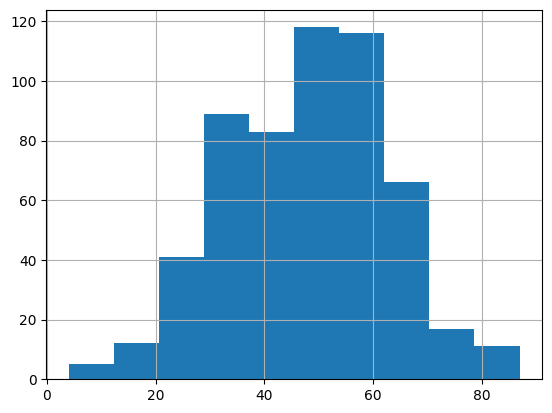

In [ ]:
test_df['Patient Age'].hist()

--- Analysis by Patient Sex ---


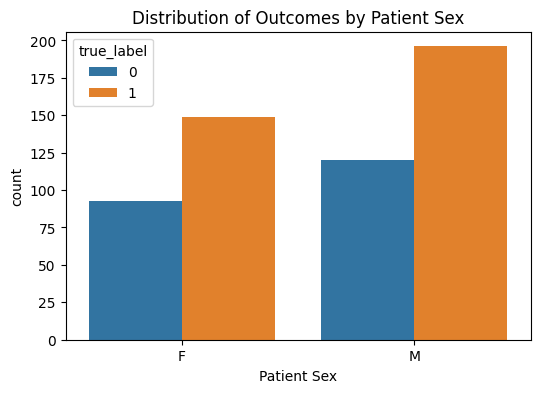


Performance Metrics by Patient Sex:


,accuracy,precision,recall,f1_score,roc_auc,count
Patient Sex,,,,,,
F,0.739669,0.883929,0.664430,0.758621,0.851916,242.0
M,0.731013,0.888112,0.647959,0.749263,0.839371,316.0



Formal Fairness Metrics (Female vs. Male):
  Equal Opportunity Difference (EOD): 0.0165
  Average Odds Difference (AOD):    0.0115


In [ ]:
# Subgroup Analysis by Patient Sex
print("Analysis by Patient Sex")

# Visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=test_df_with_preds, x=...#COMPLETE, hue='true_label')
plt.title('Distribution of Outcomes by Patient Sex')
plt.show()

# Calculate performance metrics for each subgroup
sex_metrics = test_df_with_preds.groupby(...#COMPLETE).apply(
    lambda g: pd.Series({
        'accuracy': accuracy_score(g['true_label'], g['predicted_label']),
        'precision': precision_score(g['true_label'], g['predicted_label']),
        'recall': recall_score(g['true_label'], g['predicted_label']),
        'f1_score': f1_score(g['true_label'], g['predicted_label']),
        'roc_auc': roc_auc_score(g['true_label'], g['probability']),
        'count': len(g)
    })
)
print("\nPerformance Metrics by Patient Sex:")
display(sex_metrics)

# Calculate formal fairness metrics
df_F = test_df_with_preds[test_df_with_preds[...#COMPLETE] == ...#COMPLETE]
df_M = test_df_with_preds[test_df_with_preds[...#COMPLETE] == ...#COMPLETE]

fairness_metrics_sex = compute_AOD_EOD_from_split(
    df_F['true_label'], df_F['predicted_label'],
    df_M['true_label'], df_M['predicted_label']
)
print("\nFormal Fairness Metrics (Female vs. Male):")
print(f"  Equal Opportunity Difference (EOD): {fairness_metrics_sex['EOD']:.4f}")
print(f"  Average Odds Difference (AOD):    {fairness_metrics_sex['AOD']:.4f}")


--- Analysis by Patient Age ---


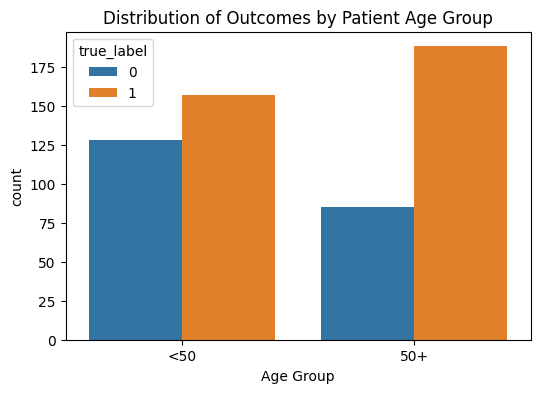


Performance Metrics by Patient Age Group:


,accuracy,precision,recall,f1_score,roc_auc,count
Age Group,,,,,,
<50,0.719298,0.881188,0.566879,0.689922,0.859325,285.0
50+,0.750916,0.889610,0.728723,0.801170,0.817272,273.0


In [ ]:
# Subgroup Analysis by Patient Age
print("\nAnalysis by Patient Age")

# Create age bins and visualize the distribution
test_df_with_preds['Age Group'] = pd.cut(test_df_with_preds[...#COMPLETE], bins=[0, 50, 100], labels=[...#COMPLETE], right=False)
plt.figure(figsize=(6, 4))
sns.countplot(data=test_df_with_preds, x='Age Group', hue='true_label')
plt.title('Distribution of Outcomes by Patient Age Group')
plt.show()

# Calculate performance metrics for each subgroup
age_metrics = test_df_with_preds.groupby('Age Group').apply(
    lambda g: pd.Series({
        'accuracy': accuracy_score(g['true_label'], g['predicted_label']),
        'precision': precision_score(g['true_label'], g['predicted_label']),
        'recall': recall_score(g['true_label'], g['predicted_label']),
        'f1_score': f1_score(g['true_label'], g['predicted_label']),
        'roc_auc': roc_auc_score(g['true_label'], g['probability']),
        'count': len(g)
    })
)
print("\nPerformance Metrics by Patient Age Group:")
display(age_metrics)

<details>
<summary>Click for & Discussion</summary>

**Interpretation of Results:**

1.  **Demographic Distributions:** You'll notice that the dataset is not perfectly balanced. There are more male patients than female patients, and the prevalence of the pathology (positive labels) differs across groups. For example, the `50+` age group has a higher rate of disease than the `<50` group. These underlying differences in the data are often where biases can originate.

2.  **Performance Gaps:** When looking at the metrics tables, you might see small differences. For instance, the ROC AUC for the `50+` group might be slightly higher than for the `<50` group. Small fluctuations are normal, but large gaps (e.g., >5% difference in ROC AUC or Recall) would be a cause for concern.

3.  **Fairness Metrics (EOD & AOD):** The key is to look at the magnitude of the EOD and AOD values.
    *   **Low Values (e.g., < 0.05):** If the EOD and AOD are very small, it suggests that the model's performance is relatively fair between the groups at this specific 0.5 decision threshold. The error rates (both false positives and false negatives) are distributed similarly.
    *   **High Values (e.g., > 0.10):** A high EOD would be a major red flag. For example, an EOD of 0.15 would mean there is a 15 percentage point difference in the model's ability to detect the disease between males and females. This is a clinically significant bias that would need to be addressed before the model could be used responsibly.

**Conclusion:** Based on this audit, you can make a more informed statement about your model's trustworthiness. For example: "While our DenseNet121 model achieves a high overall ROC AUC, our fairness audit reveals a slight performance drop for patients under 50. The model shows minimal bias with respect to patient sex, with an AOD of less than 0.02, indicating its errors are well-balanced between males and females."
</details>


Our cohort splits `297` patients under 50 and `261` aged 50 or older. This gives us also an imbalanced younger vs. older comparison. Later, we’ll check if our classifier behaves differently across these age bins (e.g. disparate error rates).

 #### **Potential Sources of Bias in the Evaluation Set**

Our dataset contains two protected attributes that are fully populated, Sex and Age. Below we outline where bias might arise and identify which attribute currently appears least affected by sampling imbalance.
### **Which Attribute Is Least Biased?**

Given the observed counts, the Sex/Gender split (44 % vs 56 %) is closer to parity than the Age split. Hence, sex currently introduces less sampling bias than age, though fairness still needs empirical validation.
### **Note on Race / Ethnicity**

No race or ethnicity values are present in this dataset. As a result, we cannot quantify nor mitigate bias along that dimension. If such information becomes available in future data collections, it should be incorporated into the fairness analysis.

Run the evaluator on the new dataframe

DenseNet 121: acc=0.8082  prec=0.8381  rec=0.8551  f1=0.8465  auc=0.8626
EfficientNet B0: acc=0.8226  prec=0.8455  rec=0.8725  f1=0.8588  auc=0.8809
Swin Transformer: acc=0.8047  prec=0.8189  rec=0.8783  f1=0.8476  auc=0.8721


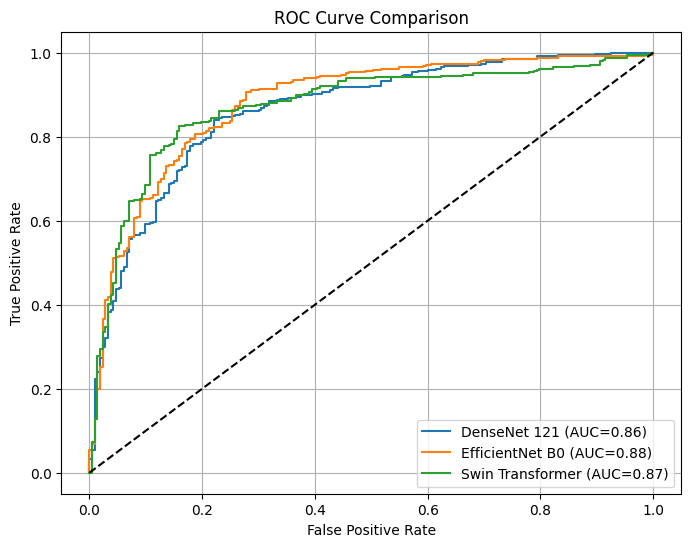

In [ ]:
test_ds = ChestXrayDataset(test_df, img_dir, transform=val_transforms)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    num_workers=8,
    pin_memory=True,
    shuffle=False
)

model_list  = [model_densenet, model_enb0, model_swin]
model_names = ['DenseNet 121', 'EfficientNet B0', 'Swin Transformer']

out = eval_models(model_list, model_names, test_loader, device=device, threshold=0.5, plot_roc=True)

DenseNet 121: acc=0.7739  prec=0.8297  rec=0.8436  f1=0.8366  auc=0.8317
EfficientNet B0: acc=0.8238  prec=0.8556  rec=0.8939  f1=0.8743  auc=0.8778
Swin Transformer: acc=0.8123  prec=0.8351  rec=0.9050  f1=0.8686  auc=0.8641


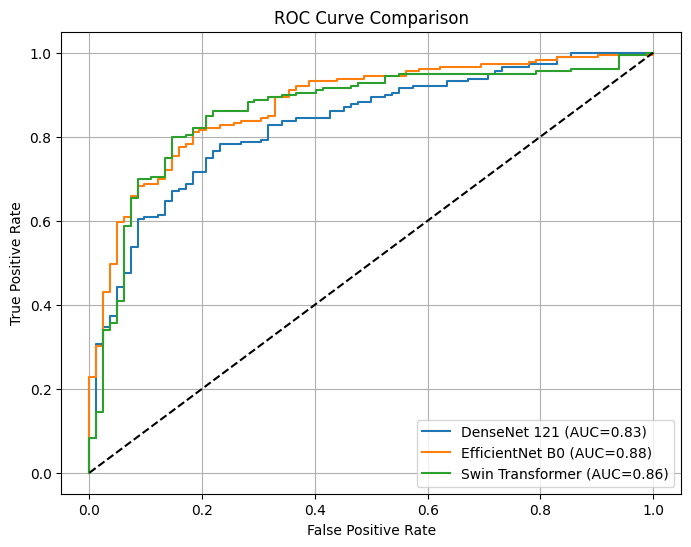

In [ ]:
test_ds = ChestXrayDataset(test_df.loc[test_df['Age Group']=='50+'], img_dir, transform=val_transforms)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    num_workers=8,
    pin_memory=True,
    shuffle=False
)

model_list  = [model_densenet, model_enb0, model_swin]
model_names = ['DenseNet 121', 'EfficientNet B0', 'Swin Transformer']

out = eval_models(model_list, model_names, test_loader, device=device, threshold=0.5, plot_roc=True)

DenseNet 121: acc=0.8384  prec=0.8471  rec=0.8675  f1=0.8571  auc=0.8808
EfficientNet B0: acc=0.8215  prec=0.8343  rec=0.8494  f1=0.8418  auc=0.8801
Swin Transformer: acc=0.7980  prec=0.8011  rec=0.8494  f1=0.8246  auc=0.8734


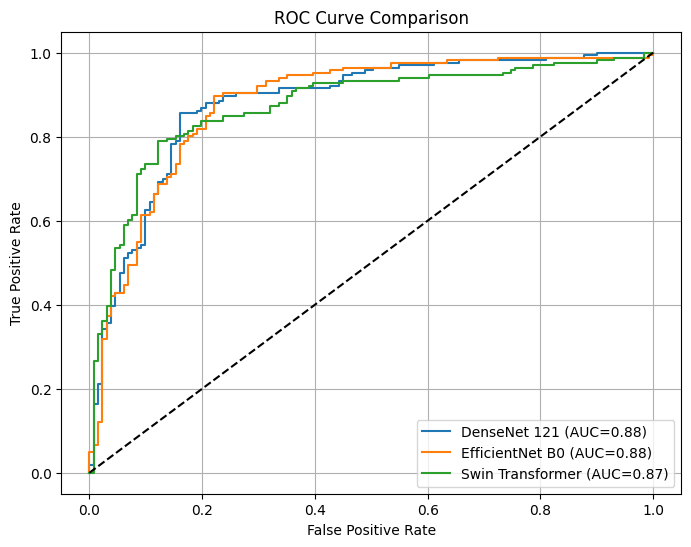

In [ ]:
test_ds = ChestXrayDataset(test_df.loc[test_df['Age Group']=='<50'], img_dir, transform=val_transforms)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    num_workers=8,
    pin_memory=True,
    shuffle=False
)

model_list  = [model_densenet, model_enb0, model_swin]
model_names = ['DenseNet 121', 'EfficientNet B0', 'Swin Transformer']

out = eval_models(model_list, model_names, test_loader, device=device, threshold=0.5, plot_roc=True)

## 9. Advanced Quality Control II: Explainable AI (XAI)

We've evaluated *what* our model predicts (its accuracy and fairness), but to truly trust it, we must understand *why* it makes a certain prediction. Is it looking at the correct, clinically relevant pathology, or is it focusing on an artifact or a shortcut in the image?

This is the domain of **Explainable AI (XAI)**. XAI techniques help us peek inside the "black box" of the neural network to make its decision-making process transparent. For this, we will use one of the most popular XAI techniques: **Grad-CAM**.

### 9.1. Establishing a Visual Ground Truth: Where is the Pathology?

Our classification model predicts *if* a disease like 'Effusion' is present in an image. But a crucial question for building trust remains: **is the model looking at the right place?** Before we can use XAI techniques like Grad-CAM to see where our model is focusing, we first need to establish our own visual ground truth.

The NIH dataset provides a file, `BBox_List_2017.csv`, containing bounding box annotations created by radiologists for a subset of the images. While our model was not trained to *draw* these boxes (a detection/localization task coming in the `detection_exercise.ipynb`), they serve as an invaluable **"answer key"** for us. They show us precisely where the clinically relevant findings are located.

In the following step, we will use our `plot_image_with_bbox` utility to visualize several examples of our chosen pathology with these ground truth boxes overlaid. Pay close attention to the location, size, and appearance of the findings. This will build your intuition and provide a crucial visual baseline for when we evaluate our model's explainability heatmaps in the next section. We will be asking: **Do our model's heatmaps align with these ground truth boxes?**

In [ ]:
!hf download albarqouni/bild-dataset --repo-type dataset --include "Classification/BBox_List_2017.csv" --local-dir ./

In [ ]:
DATA_PATH = "./Classification"
bbox_df = pd.read_csv(f'{DATA_PATH}/BBox_List_2017.csv')
bbox_df['Finding Label'].value_counts()

In [ ]:
#@title Utility visualization


def plot_image_with_bbox(image_path, bbox_data):
    # skip cleanly if file not found
    if not os.path.exists(image_path):
        print(f"[skip] Not found: {image_path}")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"[skip] Cannot read: {image_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    df = bbox_data.copy()
    # normalize bbox columns to x,y,w,h (supports both schemas)
    if 'x' not in df.columns:
        if {'Bbox [x', 'y', 'w', 'h]'}.issubset(df.columns):
            df = df.rename(columns={'Bbox [x':'x','y':'y','w':'w','h]':'h'})
        elif {'Bbox [x y w h]', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'}.issubset(df.columns):
            df = df.rename(columns={'Bbox [x y w h]':'x','Unnamed: 6':'y','Unnamed: 7':'w','Unnamed: 8':'h'})
        else:
            print("[skip] Unrecognized bbox columns"); return

    for c in ('x','y','w','h'):
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=['x','y','w','h'])

    for _, r in df.iterrows():
        x, y, w, h = int(r['x']), int(r['y']), int(r['w']), int(r['h'])
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img); plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

In [ ]:
pathology_ = "Effusion"  #@param ['Infiltrate', 'Atelectasis', 'Effusion', 'Nodule', 'Pneumothorax', 'Mass']
# Filter bbox_df for 'Infiltrate' and select a few images
bbox_df = bbox_df.loc[bbox_df['Image Index'].isin(imgs_basename)]
infiltrate_bboxes = bbox_df[bbox_df['Finding Label'] == pathology_]
num_images_to_plot = 20
images_to_plot = infiltrate_bboxes['Image Index'].unique()[:num_images_to_plot]

IMG_DIR = f'{DATA_PATH}/images'

# Plot the selected images with their bounding boxes
for img_name in images_to_plot:
    img_path = os.path.join(IMG_DIR, img_name)
    img_bboxes = infiltrate_bboxes[infiltrate_bboxes['Image Index'] == img_name]
    plot_image_with_bbox(img_path, img_bboxes)

#### Preparing for Explainability: Helper Functions

To systematically generate and visualize our Grad-CAM heatmaps, we'll use a few helper functions. This keeps our main analysis code clean and readable by abstracting away the complexities of layer selection and plotting.

Here’s a breakdown of what each function does:

*   **`get_last_conv(model, selector)`**: This is a crucial utility for finding the right layer inside our model to apply Grad-CAM.
    *   **Why it's needed:** Grad-CAM works by analyzing the feature maps of a convolutional layer. The best results typically come from the final convolutional layers, as they contain the most abstract, high-level information the model has learned.
    *   **How it works:** This function intelligently scans the model and allows us to easily select the very last conv layer (`'last_layer'`), the second-to-last (`'last_layer2'`), or even a specific named layer, giving us the flexibility to experiment.

*   **`visualize_k_per_class(...)`**: This function handles all the plotting for our XAI analysis.
    *   **Why it's needed:** We want a standardized way to compare the model's "focus" with the ground truth.
    *   **How it works:** For a given set of images and their corresponding heatmaps, it automatically finds and displays a specified number of examples for each class (e.g., 2 "No Finding" and 2 "Effusion" cases). It produces a clean, side-by-side comparison showing the original image next to the image with the Grad-CAM heatmap overlaid, complete with ground truth and prediction labels. This makes it easy to visually assess if the model is "looking" at the right place.

*   **`idx_to_name(i)`**: A simple utility to convert numeric labels (like `0`) back to their human-readable names (like `'No Finding'`) for clear plot titles.

In [ ]:
#@title Utility functions
def idx_to_name(i): return CLASS_NAMES.get(int(i), str(int(i)))

def get_last_conv(model: nn.Module, selector: str = "last_layer"):
    """
    selector:
      - 'last_layer'  -> last Conv2d
      - 'last_layer2' -> 2nd to last Conv2d
      - 'last_layer3' -> 3rd to last Conv2d
      - 'last_layer4' -> 4th to last Conv2d
      - dotted attribute path (e.g., 'backbone.body.layer3')
    Returns: (layer_name, module)
    """
    # If selector is a dotted path, try resolve directly
    if '.' in selector or (selector and selector not in {"last_layer","last_layer2","last_layer3","last_layer4"}):
        mod = _resolve_attr_path(model, selector)
        if isinstance(mod, nn.Module):
            return selector, mod
        # fall through to conv list if not found

    # Gather all Conv2d in definition order
    convs = [(name, m) for name, m in model.named_modules() if isinstance(m, nn.Conv2d)]
    if not convs:
        raise RuntimeError("No nn.Conv2d layers found; CAM needs a conv feature map. "
                           "Provide a valid attribute path or choose a CNN-backed model.")

    # Map selector to index from the end
    suffix_to_k = {"last_layer":1, "last_layer2":2, "last_layer3":3, "last_layer4":4}
    k = suffix_to_k.get(selector, 1)
    if k > len(convs):
        print(f"[warn] {selector} requested but only {len(convs)} conv layers available; using last.")
        k = 1
    return convs[-k]  # (name, module)

def visualize_k_per_class(orig_chw, heatmaps, true_labels, pred_labels, pred_confs,
                          k_per_class=5, method_name="CAM", mean=MEAN, std=STD):
    idx_neg = np.where(pred_labels == 0)[0][:k_per_class]
    idx_pos = np.where(pred_labels == 1)[0][:k_per_class]

    if len(idx_neg) < k_per_class:
        print(f"[warn] Only {len(idx_neg)} negatives available.")
    if len(idx_pos) < k_per_class:
        print(f"[warn] Only {len(idx_pos)} positives available.")

    show_indices = list(idx_neg) + list(idx_pos)

    for i in show_indices:
        # unnormalize to [0,1], CHW->HWC
        img = orig_chw[i].transpose(1, 2, 0)
        img = np.clip(std * img + mean, 0, 1)

        cam_img = show_cam_on_image(img, heatmaps[i], use_rgb=True)

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(img); plt.axis('off')
        plt.title(f"Original — Ground Truth: {idx_to_name(true_labels[i])}")

        plt.subplot(1,2,2)
        plt.imshow(cam_img); plt.axis('off')
        plt.title(f"{method_name} — Pred: {idx_to_name(pred_labels[i])} ({pred_confs[i]:.2f})")
        plt.tight_layout(); plt.show()

### 9.2 Heatmaps Heatmaps

What these CAM helpers do (short)

- **`pick_cam_constructor(name_str)`**  
  Maps a string to a CAM class and a pretty name: `"GradCAM"`, `"GradCAM++"`, or `"ScoreCAM"`.  
  Returns `(cam_class, label)` so you can build the CAM once per model/layer.

- **`run_cam_for_correct_samples(model, loader, target_layer, cam_ctor, device)`**  
  1) Builds the CAM object for `target_layer`.  
  2) Runs the model over the data and handles **multiclass** (softmax, top-1) and **binary** (sigmoid) outputs.  
  3) Keeps **only correct predictions** (to avoid explaining mistakes).  
  4) For each kept sample, sets the CAM **target = predicted class** (or index `0` for single-logit binary) and computes the heatmap.  
  5) Collects and returns:
     - `imgs_np` — input images (N, C, H, W), **unnormalized later by you** for display  
     - `heatmaps_np` — CAM heatmaps (N, H, W)  
     - `y_true_np`, `y_pred_np` — ground truth & predicted labels (N,)  
     - `y_conf_np` — confidences (top-1 prob or max(sigmoid, 1−sigmoid))  
     
Use this output to plot side-by-side: the original image and its CAM overlay, knowing all shown cases are correctly classified. Compare with the bounding boxes above to spot the pathology and assess if its correctly predicted qualitatively.


<div class="alert alert-block alert-info">
<b>Q6.</b> Implement the Core XAI Logic.

Now for the most visually insightful part of our analysis. We will use the `pytorch-grad-cam` library to generate the heatmaps that show us where our model is "looking."

Your task is to complete the core logic inside the `run_cam_for_correct_samples` function. This function is designed to iterate through our test data, find the images the model classified **correctly**, and then generate a heatmap explaining *why* the model made that correct decision.

**Your Task:**
Fill in the `...` placeholders in the code below to complete the following three critical steps:

1.  **Instantiate the CAM Object:** Create an instance of the chosen CAM method (e.g., `GradCAM`) using the provided `cam_ctor`, the `model`, and the `target_layer`.
2.  **Define the CAM Targets:** For the `pytorch-grad-cam` library, we need to specify *what* we want to explain. For a classification model, the target is the predicted class. Create a list of `ClassifierOutputTarget` objects, one for each of the correctly predicted images.
3.  **Generate the Heatmaps:** Call the `cam` object with the correct `input_tensor` and the list of `targets` you just created to generate the batch of heatmaps.

</div>

<details>
<summary>Click for Discussion</summary>

**Discussion:**

*   **Step 1** is the standard initialization for any CAM object in the library. We tell it which model and which specific layer within that model to analyze.
*   **Step 2** is conceptually the most important. We are telling Grad-CAM, "For this first image, explain the prediction for class X; for the second image, explain the prediction for class Y," and so on. Since we have already filtered for correct predictions, `preds_corr` contains the correct class index for each image, which is exactly what `ClassifierOutputTarget` needs. We create one target for each image in our correctly predicted batch (`X_corr`).
*   **Step 3** is the main execution call. We pass the batch of input image tensors (`X_corr`) and our corresponding list of targets (`targets_corr`), and the library handles the complex backpropagation and weighting to produce the final heatmaps (`hm_batch`).

By only running this analysis on correctly classified images, we ensure our visual inspection is focused on understanding the model's *successful* reasoning patterns, which is key for building trust.
</details>

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def pick_cam_constructor(name_str: str):
    s = name_str.lower().replace(" ", "")
    if "gradcam++" in s:
        return GradCAMPlusPlus, "Grad-CAM++"
    if "score" in s:
        return ScoreCAM, "Score-CAM"
    return GradCAM, "Grad-CAM"


def run_cam_for_correct_samples(model, loader, target_layer, cam_ctor, device):
    """
    This function runs a CAM method on correctly classified samples from a data loader.
    TODO: Fill in the placeholders to complete the function.
    """
    # Instantiate the CAM object
    # Hint: Use the cam_ctor (e.g., GradCAM), the model, and the target_layer
    cam = ...

    heatmaps, imgs, y_true, y_pred, y_conf = [], [], [], [], []

    for X, y in tqdm(loader, desc="Generating Heatmaps", leave=False):
        X = X.to(device)
        y_np = y.numpy()

        with torch.no_grad():
            out = model(X)
            # This part handles both binary and multi-class outputs to get predictions
            pos_prob = torch.sigmoid(out).view(-1)
            top1_idx = (pos_prob > 0.5).long()
            top1_prob = torch.where(top1_idx == 1, pos_prob, 1.0 - pos_prob)

        preds_np = top1_idx.detach().cpu().numpy()
        confs_np = top1_prob.detach().cpu().numpy()

        # Filter to keep only the samples that the model predicted correctly
        correct_mask = (preds_np == y_np)
        if correct_mask.sum() == 0:
            continue

        X_corr       = X[correct_mask]
        y_corr       = y_np[correct_mask]
        preds_corr   = preds_np[correct_mask]
        confs_corr   = confs_np[correct_mask]

        # Define the CAM targets for the correctly predicted samples
        # Hint: The target for each image is its predicted class. Create a list of
        # ClassifierOutputTarget objects using the `preds_corr` array.
        targets_corr = ...

        # Generate the heatmaps for the batch of correct predictions
        # Hint: Call the `cam` object with the input images (`X_corr`) and their targets.
        hm_batch = ...

        # --- The rest of the function collects the results ---
        heatmaps.extend(hm_batch)
        imgs.extend(X_corr.detach().cpu())
        y_true.extend(y_corr)
        y_pred.extend(preds_corr)
        y_conf.extend(confs_corr)

    if not imgs:
        print("No correct predictions were found to visualize.")
        return None

    # Package results into NumPy arrays for easy visualization
    imgs_np     = torch.stack(imgs).cpu().numpy()
    heatmaps_np = np.stack(heatmaps, axis=0)
    y_true_np   = np.array(y_true, dtype=int)
    y_pred_np   = np.array(y_pred, dtype=int)
    y_conf_np   = np.array(y_conf, dtype=float)

    return imgs_np, heatmaps_np, y_true_np, y_pred_np, y_conf_np

#### Deep Dive: How Grad-CAM Works

**Grad-CAM (Gradient-weighted Class Activation Mapping)** produces a visual heatmap that highlights the regions in an input image that were most important for a specific prediction.

-   **Hotter areas (red/yellow)** on the heatmap indicate pixels that strongly influenced the model to make its decision.
-   **Cooler areas (blue)** indicate pixels that were less influential.

It works by combining two key pieces of information:
1.  **Feature Maps:** The final convolutional layer of the network produces feature maps that contain high-level semantic information (e.g., "this area has a texture consistent with infiltration").
2.  **Gradients:** Grad-CAM calculates the "importance" (gradient) of each feature map with respect to the final prediction.

By taking a weighted average of the feature maps, Grad-CAM creates a heatmap that shows us exactly where the model "looked" to make its decision. By overlaying this on the original X-ray, we can visually confirm if our model is behaving like a radiologist or if it's being "distracted" by irrelevant information.

#### Deep Dive: How Grad-CAM++ Works

Grad-CAM++ builds on Grad-CAM but improves the localization of small or multiple objects:

- **Weighted Combination of Feature Maps**: Instead of a simple global average of gradients, Grad-CAM++ uses a weighted sum that accounts for pixel-wise contributions.

- **Better Fine-Grained Localization**: This allows the heatmap to more precisely highlight smaller regions that are critical to the prediction, especially when multiple objects or details matter.

ScoreCAM on the other had avoids gradient computation and often produces smoother, less noisy heatmaps.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Config
CLASS_NAMES = {0: "No finding", 1: pathology_}  # set `pathology_` to your label string
n_samples = 2  #@param {type: "number"}

# selector: 'last_layer'  -> last Conv2d | 'last_layer2' -> 2nd to last Conv2d etc.
layer_to_use = "last_layer"  #@param ['last_layer4', 'last_layer3', 'last_layer2', 'last_layer']
heatmap_method = "GradCAM"  # @param ['GradCAM', 'ScoreCAM', 'GradCAM++']

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

image_size_= 512
test_transforms   = transforms.Compose([
    transforms.Resize((image_size_,image_size_)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_ds   = ChestXrayDataset(test_df,   img_dir, transform=test_transforms)
test_loader   = DataLoader(test_ds,   batch_size=32, num_workers=32, pin_memory=True, shuffle=False)

# main loop
cam_ctor, cam_name = pick_cam_constructor(heatmap_method)

for model, model_name in zip(model_list, model_names):
    model.to(device).eval()
    layer_name, target_layer = get_last_conv(model, selector=layer_to_use)
    print(f"\t\n{cam_name} for {model_name} | target layer: {layer_name}")

    out = run_cam_for_correct_samples(model, test_loader, target_layer, cam_ctor, device)
    if out is None:
        print("No correct predictions to visualize."); continue

    imgs_np, heatmaps_np, y_true_np, y_pred_np, y_conf_np = out
    visualize_k_per_class(imgs_np, heatmaps_np, y_true_np, y_pred_np, y_conf_np,
                          k_per_class=n_samples, method_name=cam_name, mean=MEAN, std=STD)

<div class="alert alert-block alert-info">
<b>Q6.</b> In the previous cell, we created the <code>GradCAM heatmaps</code>.

- Observe the code and the plots, and interpret how well the model is performing
- What remarks can you identify with respect to the <code>GradCAM</code>
- Can you spot the lesions in the image under the predicted class activation maps? Where do the difficulties arise?

# Conclusion and Final Thoughts

Congratulations on completing this comprehensive, hands-on journey through medical image classification!

Over the course of this notebook, you have successfully built, trained, and evaluated deep learning models from start to finish. You have gone beyond mere training—you have engaged in critical practices that transform a simple experiment into a robust, interpretable AI system.

## Key Achievements

- You successfully handled and prepared a real-world medical imaging dataset, including preprocessing and normalization.
- You built custom PyTorch `Dataset` and `DataLoader` pipelines tailored for classification tasks.
- You trained state-of-the-art models (DenseNet, EfficientNet, Swin Transformer) and evaluated them on unseen test data.
- You implemented advanced evaluation metrics beyond simple accuracy, including precision, recall, F1-score, and AUROC and explored potential bias and fairness.
- You applied explainable AI techniques such as Grad-CAM, Grad-CAM++, and Score-CAM to interpret model predictions and identify the regions of the X-rays that influenced each decision.

## Key Takeaways

- **Data is foundational:** A thorough understanding of your dataset, including class balance and preprocessing, is essential for successful model training.  
- **Evaluation is multi-dimensional:** Relying on a single metric is insufficient. Metrics like AUROC, F1-score, and visual inspection of correctly and incorrectly classified images give a complete picture of model performance.  
- **Interpretability builds trust:** In high-stakes domains like medicine, it’s crucial to understand why models make their decisions and assess their potential bias. Techniques like Grad-CAM help clinicians trust AI-assisted predictions.

## Next Steps

This notebook provides a strong foundation for further exploration. Here are some directions to extend your work:

1. **Include Negative Samples:** Incorporate non-diseased cases to create a more comprehensive diagnostic model capable of both detection and classification.  
2. **Experiment with Architectures:** Try alternative architectures or ensemble approaches to improve classification performance.  
3. **Hyperparameter Optimization:** Systematically tune learning rates, batch sizes, and data augmentation strategies to improve metrics like AUROC and F1-score.  
4. **3D Medical Imaging:** Extend these methods to 3D datasets (CT or MRI scans) to handle more complex structures and richer diagnostic information.  
5. **Model Explainability:** Explore LIME or integrated gradients alongside Grad-CAM to provide multi-faceted interpretability for clinical decision support.

By following these practices, you have not only trained accurate models but also built a framework for safe, interpretable, and clinically useful AI in medical imaging.


> 90 minutes